#**Machine Learning Project #1**
The objective of this project is to make a machine learning model using Random Forest and XGBoost algorithm to classify the stage of Liver Cirrhosis. The steps included EDA, preprocessing, modelling, hyperparameter tuning using GridSearchCV, model evaluation and overall evaluation.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from dython.nominal import associations
import xgboost as xgb

from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, roc_curve
from sklearn.model_selection import StratifiedKFold

from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier

### **Data Loading**

In [ ]:
df = pd.read_csv('1A.tsv', sep='\t')
df.head()

,ID,Registration Date,Drug,Birth Date,Gender,Ascites,Hepatomegaly,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alkaline Phospatase (U/L),SGOT,Tryglicerides,Platelets,Prothrombin,Stage
0,1,2023/11/07,D-penicillamine,1966/03/07,F,Y,Y,Y,14.5,261.0,2.60,156.0,1718.0,137.95,172.0,190.0,12.2,Stage4
1,2,2012/08/16,D-penicillamine,1968/07/01,F,N,Y,N,1.1,302.0,4.14,54.0,7394.8,113.52,88.0,221.0,10.6,stage_3
2,3,2022/03/05,D-penicillamine,1954/11/15,M,N,N,S,1.4,NaN,3.48,210.0,516.0,96.10,55.0,151.0,12.0,Stage4
3,4,2019/09/04,D-penicillamine,1970/03/16,F,N,Y,S,1.8,244.0,2.54,64.0,6121.8,60.63,92.0,183.0,10.3,Stage4
4,5,2020/10/29,Placebo,1986/11/03,F,N,Y,N,3.4,NaN,3.53,143.0,671.0,113.15,72.0,136.0,10.9,stage_3


## **EDA**

In [ ]:
df.shape

(418, 18)

In [ ]:
df.columns

Index(['ID', 'Registration Date', 'Drug', 'Birth Date', 'Gender', 'Ascites',
       'Hepatomegaly', 'Edema', 'Bilirubin', 'Cholesterol', 'Albumin',
       'Copper', 'Alkaline Phospatase (U/L)', 'SGOT', 'Tryglicerides',
       'Platelets', 'Prothrombin', 'Stage'],
      dtype='object')

In [ ]:
df.dtypes

,0
ID,int64
Registration Date,object
Drug,object
Birth Date,object
Gender,object
Ascites,object
Hepatomegaly,object
Edema,object
Bilirubin,float64
Cholesterol,float64


In [ ]:
df.isnull().sum()

,0
ID,0
Registration Date,0
Drug,106
Birth Date,0
Gender,0
Ascites,106
Hepatomegaly,106
Edema,0
Bilirubin,0
Cholesterol,338


There are missing values in several variables, such as Cholesterol, Copper, Drug, Ascites, Hepatomegaly, Alkaline Phosphatase (U/L), SGOT, Platelets, Prothrombin, and Stage.

In [ ]:
variables = ['Cholesterol', 'Copper', 'Drug', 'Ascites', 'Hepatomegaly',
             'Alkaline Phospatase (U/L)', 'SGOT', 'Platelets', 'Prothrombin', 'Stage']

for var in variables:
    percentage_missing = df[var].isnull().values.mean() * 100
    print(f"{var}: {percentage_missing:.2f}%")

Cholesterol: 80.86%
Copper: 25.84%
Drug: 25.36%
Ascites: 25.36%
Hepatomegaly: 25.36%
Alkaline Phospatase (U/L): 25.36%
SGOT: 25.36%
Platelets: 2.63%
Prothrombin: 0.48%
Stage: 1.44%


There is approximately 80% missing data in the Cholesterol column, so this column will be dropped later. The Drug, Ascites, Hepatomegaly, SGOT, Copper, and Alkaline Phosphatase columns, each have about 25% missing data. The variables Platelets, Prothrombin, and Stage have less than 3% missing data. To do imputation for numerical variables, it is necessary to first check whether there are any outliers. Then, the missing data will be filled using the mean of each column if there are no outliers, and the median if outliers are present.


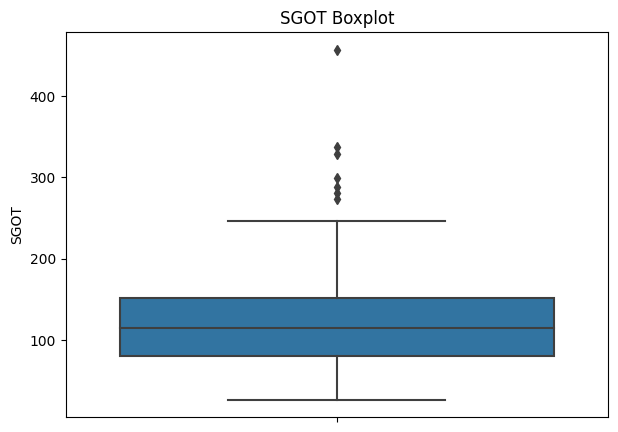

In [ ]:
plt.figure(figsize=(7,5))
sns.boxplot(y = df['SGOT'])
plt.title("SGOT Boxplot")
plt.show()

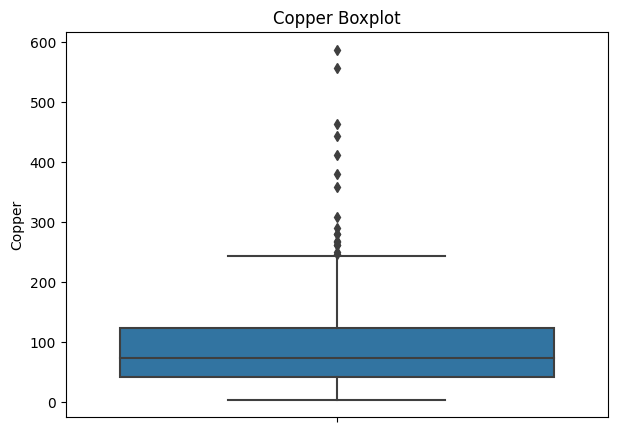

In [ ]:
plt.figure(figsize=(7,5))
sns.boxplot(y = df['Copper'])
plt.title("Copper Boxplot")
plt.show()

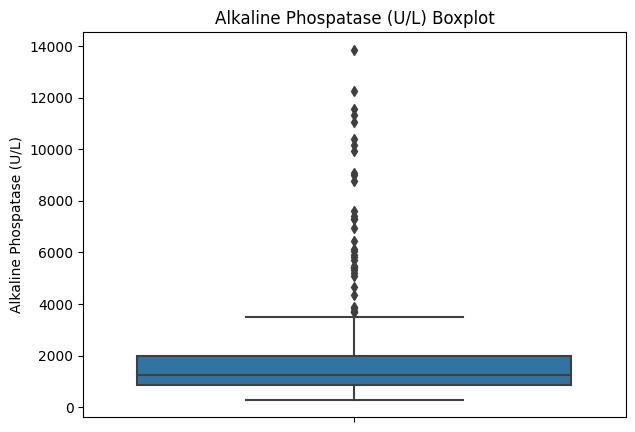

In [ ]:
plt.figure(figsize=(7,5))
sns.boxplot(y = df['Alkaline Phospatase (U/L)'])
plt.title("Alkaline Phospatase (U/L) Boxplot")
plt.show()

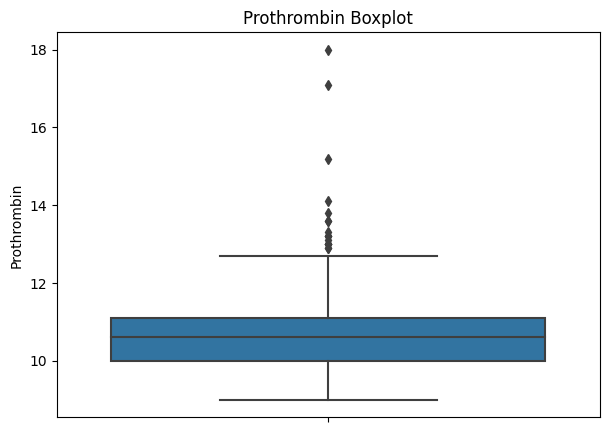

In [ ]:
plt.figure(figsize=(7,5))
sns.boxplot(y = df['Prothrombin'])
plt.title("Prothrombin Boxplot")
plt.show()

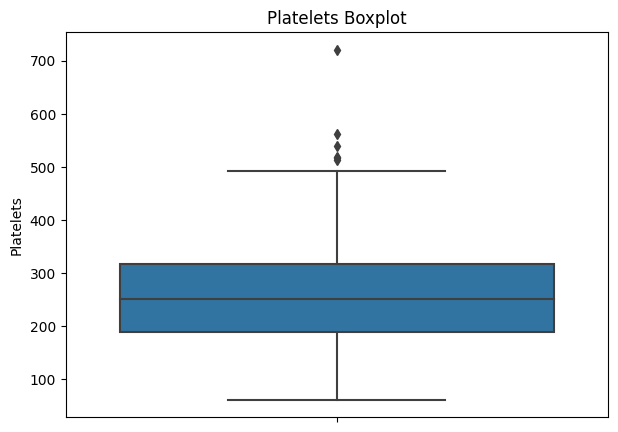

In [ ]:
plt.figure(figsize=(7,5))
sns.boxplot(y = df['Platelets'])
plt.title("Platelets Boxplot")
plt.show()

Since outliers are present in all numerical variables, the missing data will be filled using the median. Meanwhile, the mode will be used for all categorical data.


In [ ]:
numerical_medians = df.select_dtypes(include=['number']).median()
print("Median untuk kolom numerik :")
print(numerical_medians)


Median untuk kolom numerik :
ID                            209.50
Bilirubin                       1.40
Cholesterol                   284.50
Albumin                         3.53
Copper                         73.00
Alkaline Phospatase (U/L)    1259.00
SGOT                          114.70
Tryglicerides                  85.00
Platelets                     251.00
Prothrombin                    10.60
dtype: float64


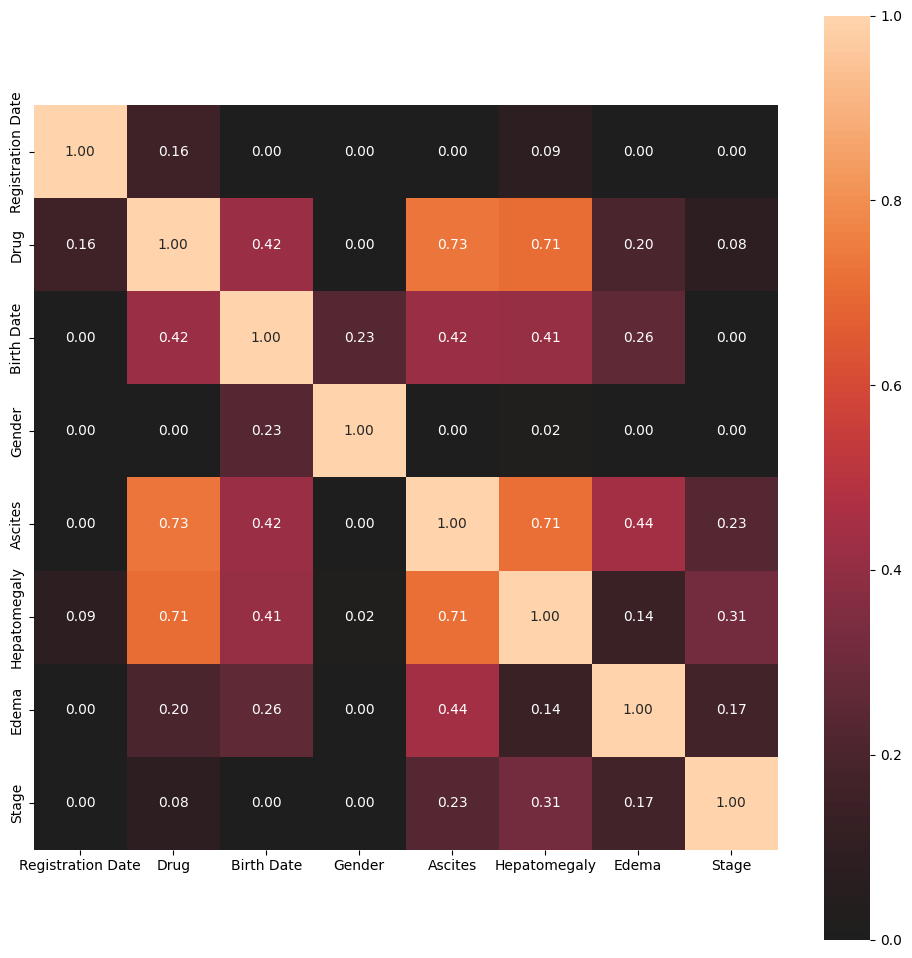

In [ ]:
categorical_columns = df.select_dtypes(include=['object', 'category']).columns
association_dictionary = associations(df[categorical_columns], figsize=(12,12))


From the correlation plot above, it can be seen that Hepatomegaly, Ascites, and Edema have the strongest associations with the Stage variable, although the correlations are still relatively weak.


## **Preprocessing**

In [ ]:
df.head()

,ID,Registration Date,Drug,Birth Date,Gender,Ascites,Hepatomegaly,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alkaline Phospatase (U/L),SGOT,Tryglicerides,Platelets,Prothrombin,Stage
0,1,2023/11/07,D-penicillamine,1966/03/07,F,Y,Y,Y,14.5,261.0,2.60,156.0,1718.0,137.95,172.0,190.0,12.2,Stage4
1,2,2012/08/16,D-penicillamine,1968/07/01,F,N,Y,N,1.1,302.0,4.14,54.0,7394.8,113.52,88.0,221.0,10.6,stage_3
2,3,2022/03/05,D-penicillamine,1954/11/15,M,N,N,S,1.4,NaN,3.48,210.0,516.0,96.10,55.0,151.0,12.0,Stage4
3,4,2019/09/04,D-penicillamine,1970/03/16,F,N,Y,S,1.8,244.0,2.54,64.0,6121.8,60.63,92.0,183.0,10.3,Stage4
4,5,2020/10/29,Placebo,1986/11/03,F,N,Y,N,3.4,NaN,3.53,143.0,671.0,113.15,72.0,136.0,10.9,stage_3


Since this case is related to health or medical issues, age is a highly influential factor. Moreover, the Birth Date column shows correlation with other columns. Therefore, the column will be retained, but it will first be converted into a standard integer age format.

In [ ]:
from datetime import datetime

df['Birth Date'] = pd.to_datetime(df['Birth Date'], format='%Y/%m/%d')
current_date = datetime.now()
df['Age'] = df['Birth Date'].apply(lambda x: (current_date - x).days // 365)
print(df)

      ID Registration Date             Drug Birth Date Gender Ascites  \
0      1        2023/11/07  D-penicillamine 1966-03-07      F       Y   
1      2        2012/08/16  D-penicillamine 1968-07-01      F       N   
2      3        2022/03/05  D-penicillamine 1954-11-15      M       N   
3      4        2019/09/04  D-penicillamine 1970-03-16      F       N   
4      5        2020/10/29          Placebo 1986-11-03      F       N   
..   ...               ...              ...        ...    ...     ...   
413  414        2023/01/30              NaN 1957-12-11      F     NaN   
414  415        2021/12/04              NaN 1985-12-11      F     NaN   
415  416        2022/01/21              NaN 1967-12-12      F     NaN   
416  417        2023/01/20              NaN 1966-12-11      F     NaN   
417  418        2022/04/10              NaN 1971-12-12      F     NaN   

    Hepatomegaly Edema  Bilirubin  Cholesterol  Albumin  Copper  \
0              Y     Y       14.5        261.0     2.60 

In [ ]:
df

,ID,Registration Date,Drug,Birth Date,Gender,Ascites,Hepatomegaly,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alkaline Phospatase (U/L),SGOT,Tryglicerides,Platelets,Prothrombin,Stage,Age
0,1,2023/11/07,D-penicillamine,1966-03-07,F,Y,Y,Y,14.5,261.0,2.60,156.0,1718.0,137.95,172.0,190.0,12.2,Stage4,58
1,2,2012/08/16,D-penicillamine,1968-07-01,F,N,Y,N,1.1,302.0,4.14,54.0,7394.8,113.52,88.0,221.0,10.6,stage_3,56
2,3,2022/03/05,D-penicillamine,1954-11-15,M,N,N,S,1.4,NaN,3.48,210.0,516.0,96.10,55.0,151.0,12.0,Stage4,70
3,4,2019/09/04,D-penicillamine,1970-03-16,F,N,Y,S,1.8,244.0,2.54,64.0,6121.8,60.63,92.0,183.0,10.3,Stage4,54
4,5,2020/10/29,Placebo,1986-11-03,F,N,Y,N,3.4,NaN,3.53,143.0,671.0,113.15,72.0,136.0,10.9,stage_3,38
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
413,414,2023/01/30,NaN,1957-12-11,F,NaN,NaN,N,1.2,NaN,2.96,NaN,NaN,NaN,-1.0,174.0,10.9,stage_3,67
414,415,2021/12/04,NaN,1985-12-11,F,NaN,NaN,N,0.9,NaN,3.83,NaN,NaN,NaN,-1.0,180.0,11.2,Stage4,39
415,416,2022/01/21,NaN,1967-12-12,F,NaN,NaN,N,1.6,NaN,3.42,NaN,NaN,NaN,-1.0,143.0,9.9,stage_3,57
416,417,2023/01/20,NaN,1966-12-11,F,NaN,NaN,N,0.8,NaN,3.75,NaN,NaN,NaN,-1.0,269.0,10.4,stage_3,58


In [ ]:
df = df.drop(columns="ID")
df = df.drop(columns="Registration Date")
df = df.drop(columns="Cholesterol")
df = df.drop(columns="Birth Date")

df

,Drug,Gender,Ascites,Hepatomegaly,Edema,Bilirubin,Albumin,Copper,Alkaline Phospatase (U/L),SGOT,Tryglicerides,Platelets,Prothrombin,Stage,Age
0,D-penicillamine,F,Y,Y,Y,14.5,2.60,156.0,1718.0,137.95,172.0,190.0,12.2,Stage4,58
1,D-penicillamine,F,N,Y,N,1.1,4.14,54.0,7394.8,113.52,88.0,221.0,10.6,stage_3,56
2,D-penicillamine,M,N,N,S,1.4,3.48,210.0,516.0,96.10,55.0,151.0,12.0,Stage4,70
3,D-penicillamine,F,N,Y,S,1.8,2.54,64.0,6121.8,60.63,92.0,183.0,10.3,Stage4,54
4,Placebo,F,N,Y,N,3.4,3.53,143.0,671.0,113.15,72.0,136.0,10.9,stage_3,38
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
413,NaN,F,NaN,NaN,N,1.2,2.96,NaN,NaN,NaN,-1.0,174.0,10.9,stage_3,67
414,NaN,F,NaN,NaN,N,0.9,3.83,NaN,NaN,NaN,-1.0,180.0,11.2,Stage4,39
415,NaN,F,NaN,NaN,N,1.6,3.42,NaN,NaN,NaN,-1.0,143.0,9.9,stage_3,57
416,NaN,F,NaN,NaN,N,0.8,3.75,NaN,NaN,NaN,-1.0,269.0,10.4,stage_3,58


#### **Filling missing datas**

Numerical Columns

In [ ]:
df['Copper'] = df['Copper'].fillna(73)
df['Alkaline Phospatase (U/L)'] = df['Alkaline Phospatase (U/L)'].fillna(1259)
df['SGOT'] = df['SGOT'].fillna(114.7)
df['Platelets'] = df['Platelets'].fillna(251)
df['Prothrombin'] = df['Prothrombin'].fillna(10.6)

Categorical Columns

The mode() function returns a Series containing one or more mode values from a column. If thre is more than one mode, mode() will return multiple values. Therefore, mode() can't be used directly to fill NaN values because fillna() requires a single value, not a Series. To resolve this, iloc[0} is used to select the mode value, which is then used to fill the NaN values.

In [ ]:
df['Drug'] = df['Drug'].fillna(df['Drug'].mode().iloc[0])
df['Ascites'] = df['Ascites'].fillna(df['Ascites'].mode().iloc[0])
df['Hepatomegaly'] = df['Hepatomegaly'].fillna(df['Hepatomegaly'].mode().iloc[0])
df['Stage'] = df['Stage'].fillna(df['Stage'].mode().iloc[0])

In [ ]:
df.isnull().sum()

Drug                         0
Gender                       0
Ascites                      0
Hepatomegaly                 0
Edema                        0
Bilirubin                    0
Albumin                      0
Copper                       0
Alkaline Phospatase (U/L)    0
SGOT                         0
Tryglicerides                0
Platelets                    0
Prothrombin                  0
Stage                        0
Age                          0
dtype: int64

In [ ]:
df

,Drug,Gender,Ascites,Hepatomegaly,Edema,Bilirubin,Albumin,Copper,Alkaline Phospatase (U/L),SGOT,Tryglicerides,Platelets,Prothrombin,Stage,Age
0,D-penicillamine,F,Y,Y,Y,14.5,2.60,156.0,1718.0,137.95,172.0,190.0,12.2,Stage4,58
1,D-penicillamine,F,N,Y,N,1.1,4.14,54.0,7394.8,113.52,88.0,221.0,10.6,stage_3,56
2,D-penicillamine,M,N,N,S,1.4,3.48,210.0,516.0,96.10,55.0,151.0,12.0,Stage4,70
3,D-penicillamine,F,N,Y,S,1.8,2.54,64.0,6121.8,60.63,92.0,183.0,10.3,Stage4,54
4,Placebo,F,N,Y,N,3.4,3.53,143.0,671.0,113.15,72.0,136.0,10.9,stage_3,38
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
413,D-penicillamine,F,N,Y,N,1.2,2.96,73.0,1259.0,114.70,-1.0,174.0,10.9,stage_3,67
414,D-penicillamine,F,N,Y,N,0.9,3.83,73.0,1259.0,114.70,-1.0,180.0,11.2,Stage4,39
415,D-penicillamine,F,N,Y,N,1.6,3.42,73.0,1259.0,114.70,-1.0,143.0,9.9,stage_3,57
416,D-penicillamine,F,N,Y,N,0.8,3.75,73.0,1259.0,114.70,-1.0,269.0,10.4,stage_3,58


### **Data Encoding and Data Splitting**

In [ ]:
def LabelEncoder_all(df):
    df = df.copy()
    LabelEncoding = LabelEncoder()
    for column in df.columns:
        if df[column].dtype == 'object':
            df[column] = LabelEncoding.fit_transform(df[column])

    return df

df2 = LabelEncoder_all(df)

In [ ]:
df2

,Drug,Gender,Ascites,Hepatomegaly,Edema,Bilirubin,Albumin,Copper,Alkaline Phospatase (U/L),SGOT,Tryglicerides,Platelets,Prothrombin,Stage,Age
0,0,0,1,1,2,14.5,2.60,156.0,1718.0,137.95,172.0,190.0,12.2,2,58
1,0,0,0,1,0,1.1,4.14,54.0,7394.8,113.52,88.0,221.0,10.6,3,56
2,0,1,0,0,1,1.4,3.48,210.0,516.0,96.10,55.0,151.0,12.0,2,70
3,0,0,0,1,1,1.8,2.54,64.0,6121.8,60.63,92.0,183.0,10.3,2,54
4,1,0,0,1,0,3.4,3.53,143.0,671.0,113.15,72.0,136.0,10.9,3,38
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
413,0,0,0,1,0,1.2,2.96,73.0,1259.0,114.70,-1.0,174.0,10.9,3,67
414,0,0,0,1,0,0.9,3.83,73.0,1259.0,114.70,-1.0,180.0,11.2,2,39
415,0,0,0,1,0,1.6,3.42,73.0,1259.0,114.70,-1.0,143.0,9.9,3,57
416,0,0,0,1,0,0.8,3.75,73.0,1259.0,114.70,-1.0,269.0,10.4,3,58


In [ ]:
X = df2.drop(columns='Stage')
y = df2['Stage']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((334, 14), (84, 14), (334,), (84,))

In [ ]:
y

0      2
1      3
2      2
3      2
4      3
      ..
413    3
414    2
415    3
416    3
417    2
Name: Stage, Length: 418, dtype: int32

In [ ]:
X

,Drug,Gender,Ascites,Hepatomegaly,Edema,Bilirubin,Albumin,Copper,Alkaline Phospatase (U/L),SGOT,Tryglicerides,Platelets,Prothrombin,Age
0,0,0,1,1,2,14.5,2.60,156.0,1718.0,137.95,172.0,190.0,12.2,58
1,0,0,0,1,0,1.1,4.14,54.0,7394.8,113.52,88.0,221.0,10.6,56
2,0,1,0,0,1,1.4,3.48,210.0,516.0,96.10,55.0,151.0,12.0,70
3,0,0,0,1,1,1.8,2.54,64.0,6121.8,60.63,92.0,183.0,10.3,54
4,1,0,0,1,0,3.4,3.53,143.0,671.0,113.15,72.0,136.0,10.9,38
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
413,0,0,0,1,0,1.2,2.96,73.0,1259.0,114.70,-1.0,174.0,10.9,67
414,0,0,0,1,0,0.9,3.83,73.0,1259.0,114.70,-1.0,180.0,11.2,39
415,0,0,0,1,0,1.6,3.42,73.0,1259.0,114.70,-1.0,143.0,9.9,57
416,0,0,0,1,0,0.8,3.75,73.0,1259.0,114.70,-1.0,269.0,10.4,58


## **Random Forests Modelling**

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, classification_report

rf = RandomForestClassifier(random_state=42)
param_grid_rf = {
    'n_estimators': [200, 300, 400],
    'max_depth': [None, 10, 20],
    'min_samples_split': [5, 10, 15]
}
grid_search_rf = GridSearchCV(estimator=rf, param_grid=param_grid_rf, cv=5, n_jobs=1, verbose=1)
grid_search_rf.fit(X_train, y_train)

print("Best Random Forest Hyperparameters:", grid_search_rf.best_params_)

best_rf = grid_search_rf.best_estimator_
y_pred_rf = best_rf.predict(X_test)

print("Random Forest Accuracy:", accuracy_score(y_test, y_pred_rf))
print("Random Forest Classification Report:\n", classification_report(y_test, y_pred_rf))


Fitting 5 folds for each of 27 candidates, totalling 135 fits
Best Random Forest Hyperparameters: {'max_depth': None, 'min_samples_split': 10, 'n_estimators': 300}
Random Forest Accuracy: 0.5
Random Forest Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         3
           1       0.20      0.06      0.10        16
           2       0.58      0.58      0.58        31
           3       0.48      0.68      0.56        34

    accuracy                           0.50        84
   macro avg       0.31      0.33      0.31        84
weighted avg       0.45      0.50      0.46        84



c:\Users\srbol\anaconda3\envs\deep_learning\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\srbol\anaconda3\envs\deep_learning\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\srbol\anaconda3\envs\deep_learning\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result)

## **XGBoost Modelling**

In [ ]:
xgb_model = xgb.XGBClassifier(random_state=42)
param_grid_xgb = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 6, 10, 15],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}
grid_search_xgb = GridSearchCV(estimator=xgb_model, param_grid=param_grid_xgb, cv=5, n_jobs=1, verbose=1)
grid_search_xgb.fit(X_train, y_train)
print("Best XGBoost Hyperparameters:", grid_search_xgb.best_params_)

best_xgb = grid_search_xgb.best_estimator_
y_pred_xgb = best_xgb.predict(X_test)

print("XGBoost Accuracy:", accuracy_score(y_test, y_pred_xgb))
print("XGBoost Classification Report:\n", classification_report(y_test, y_pred_xgb))


Fitting 5 folds for each of 144 candidates, totalling 720 fits
Best XGBoost Hyperparameters: {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'subsample': 1.0}
XGBoost Accuracy: 0.47619047619047616
XGBoost Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         3
           1       0.12      0.06      0.08        16
           2       0.56      0.61      0.58        31
           3       0.48      0.59      0.53        34

    accuracy                           0.48        84
   macro avg       0.29      0.32      0.30        84
weighted avg       0.42      0.48      0.44        84



c:\Users\srbol\anaconda3\envs\deep_learning\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\srbol\anaconda3\envs\deep_learning\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\srbol\anaconda3\envs\deep_learning\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result)

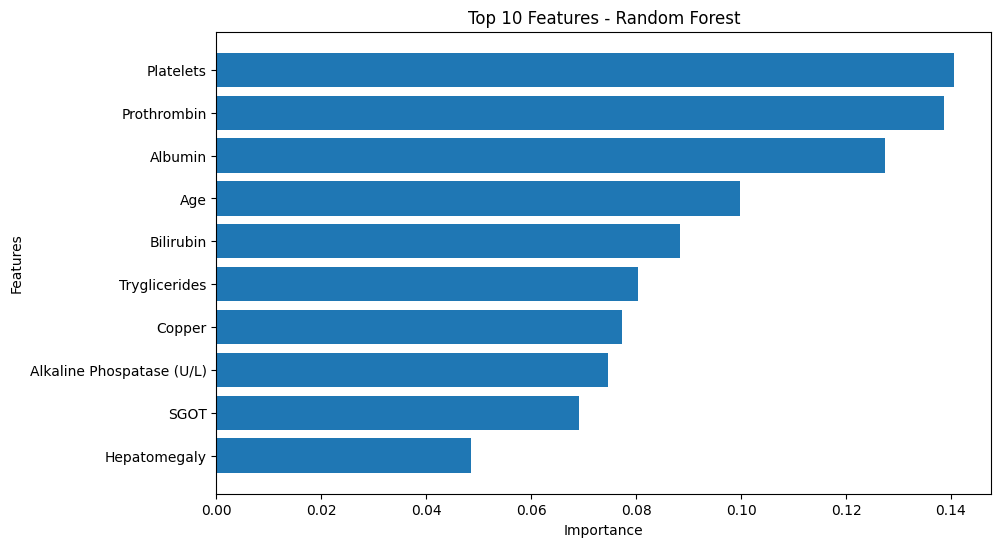

Random Forest Feature Importance:
Feature: Platelets, Importance: 0.14064714155888058
Feature: Prothrombin, Importance: 0.13868478388921668
Feature: Albumin, Importance: 0.12749522530116708
Feature: Age, Importance: 0.09983640323366533
Feature: Bilirubin, Importance: 0.08836010966060273
Feature: Tryglicerides, Importance: 0.08044665441218002
Feature: Copper, Importance: 0.07734704845708233
Feature: Alkaline Phospatase (U/L), Importance: 0.07464405599669657
Feature: SGOT, Importance: 0.06907454648278648
Feature: Hepatomegaly, Importance: 0.048593336763497356


In [ ]:
importances_rf = best_rf.feature_importances_
indices_rf = np.argsort(importances_rf)[::-1]

plt.figure(figsize=(10, 6))
plt.title("Top 10 Features - Random Forest")
plt.barh(range(10), importances_rf[indices_rf[:10]], align="center")
plt.yticks(range(10), [X_train.columns[i] for i in indices_rf[:10]])
plt.xlabel('Importance')
plt.ylabel('Features')
plt.gca().invert_yaxis()
plt.show()
print("Random Forest Feature Importance:")
for i in indices_rf[:10]:
    print(f"Feature: {X_train.columns[i]}, Importance: {importances_rf[i]}")


## **Evaluation**

From the Random Forest model results above, it can be seen that this model only achieved an accuracy of 0.5, a precision of 0.45, and an F1 score of 0.46. This means the model is only able to correctly predict 50% of the total samples. On the other hand, the XGBoost model achieved an accuracy of 0.48, a precision of 0.40, and an F1 score of 0.43. Among the two models built, the Random Forest model demonstrated better performance.

Several factors may affect the performance of the models, such as class imbalance and unequal distribution of data across labels. Below is the explanation:
1. **Class Imbalance** -> This can be seen from the classification report for classes 0 and 1. Both models, Random Forest and XGBoost, failed to predict these two classes. This could also be due to the small number of support values or valid data. In contrast, classes 2 and 3 are the majority classes with higher support values. This imbalance in the data can significantly impact model performance, especially when there are very few samples for certain classes.

2. **Data Size** -> A dataset with only 400 rows is considered very small and can worsen the imbalance issue. The relatively small dataset size can make it difficult for the model to generalize, particularly for classes with low sample or support values.


Therefore, it can be concluded that class imbalance is suspected to be the main issue. This is followed by the small dataset size, with classes 0 and 1 having relatively few samples, while classes 2 and 3 are the majority. In addition, there is also a possibility that the model misclassified data labeled as "0" or "1" as "2" or "3" due to insufficient learning from those minority classes.

## **Feature Analysis**

The following is an analysis of the features used:
1. Platelets, Prothrombin, and Albumin emerged as the top three most important features, each with an importance score above 0.12, making them the most influential in predicting the target variable.
2. Age and Bilirubin also play significant roles, followed by Triglycerides and Copper, which still have relatively high importance scores.
3. SGOT and Hepatomegaly rank lower in terms of importance, with Hepatomegaly having the least impact, although it still contributes to the classification decisions.   

The Random Forest model successfully identified several features that play a crucial role in diagnosing liver disease. Features related to blood indicators, such as Platelets, Prothrombin, and Albumin, have the highest importance scores. This indicates that the model relies on medically significant factors for classification. Since these features hold high importance, it is strongly recommended to ensure the quality of their data. This is because the data from these features have a major impact on the model's learning process.